# COVID-19 Bayesian Real-time estimation of $R_t$

This work is mainly based on [this article][1], and [this blog post][2], 
which again refers to [this notebook][3]. The idea is to iterate equation
13 from the article,

$$P[R|\Delta T(t+1) \leftarrow \Delta T(t)] = \frac{P[\Delta T(t+1) \leftarrow \Delta T(t)|R]\, P[R]}{P[\Delta T(t+1) \leftarrow \Delta T(t)]}\,.$$

The denominator is independent of $R$. The factor $P[R]$ in the numerator
can be substituted for the estimation we get from this equation at the 
previous time step.

[1]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185#pone.0002185-Bjornstad1
[2]: http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/
[3]: https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [71]:
import pandas
import matplotlib.pyplot as plt
import numpy


url_confirmed = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
raw_df_confirmed = pandas.read_csv(url_confirmed)
df_c = raw_df_confirmed.copy()
del df_c['Long']
del df_c['Lat']
df_c = df_c.set_index(['Country/Region','Province/State'])\
           .transpose() # transpose to get dates as rows
# make a proper datetime index
df_c = df_c.set_index(pandas.to_datetime(df_c.index))

In [79]:
country, province = 'Italy', float('Nan')

In [80]:
de = df_c[country, province]
de = de[de.index[(de > 50)][0]:]
deltas = (de - de.shift(1)).dropna()

# Raw Counts

Using raw counts won't work in most cases, since the data are so rough the successive
likelihood functions won't have common support.

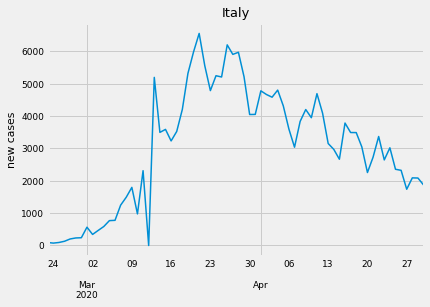

In [109]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases")
deltas.plot.line()
plt.savefig(f'{country}_raw.png', dpi=300, bbox_inches='tight')

# Smmothing

We smooth the data using a 7-day Gaussian window.

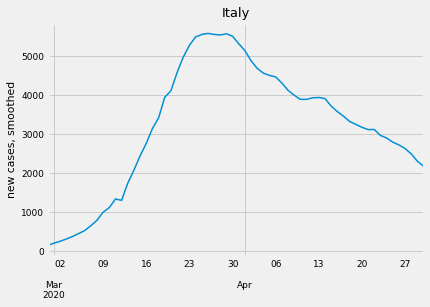

In [108]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases, smoothed")
k = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()
k.plot.line()
plt.savefig(f'{country}_smooth.png', dpi=300, bbox_inches='tight')

# Likelihood function

As the likelihood function, we use a Poisson distribution. The $\lambda$ parameter
can be estimated from equation 6 of the artilce,

$$\Delta T(t+1) = b(R_t)\Delta T(t)\,$$

with

$$b(R_t) \approx \exp\left\{ \tau \gamma (R_t - 1) \right\}\,.$$

For our data, $\tau = 1$, and $\gamma$ is the inverse of the infectuous period
of around 5.2 days according to [this study][Ganyani]

## TODO

Use uncertainty in $\gamma$.

[Ganyani]: https://www.medrxiv.org/content/10.1101/2020.03.05.20031815v1

In [85]:
tau = 1

In [86]:
import scipy

In [87]:
r_range = numpy.linspace(0, 10, 500)

In [88]:
Tc = 5.2
gamma = 1/Tc
lambdas = numpy.outer(k[:-1],  numpy.exp(tau*gamma*(r_range - 1)))

In [89]:
import scipy.stats

In [90]:
L = scipy.stats.poisson.pmf(k[1:], lambdas.T)

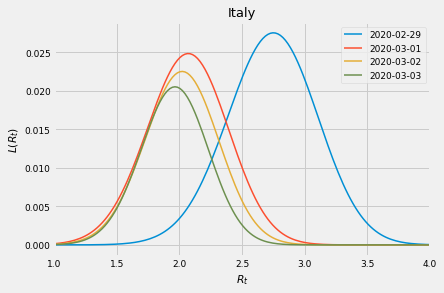

In [107]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
for i in range(4):
    plt.plot(r_range, L[:,i], label=k.index[i].date())
plt.xlabel("$R_t$")
plt.xlim((1, 4))
plt.legend()
plt.title(country)
plt.ylabel('$L(R_t)$')
plt.savefig(f"{country}_likelihood.png", dpi=300, bbox_inches="tight")

# Iterative Bayesian Updates

Now we update our estimate. We choose a window function instead of going back through the whole time series since a strong prior > 1 will prevent us from dipping under 1 at all.

In [101]:
P  = L.copy()
#P[:,0] /= P[0].sum()
#for i in range(1, P.shape[1]):
#    P[:,i] *= P[:,i-1]
#    P[:,i] /= P[:,i].sum()
W = 2
for i in range(L.shape[1]):
    P[:,i] = L[:,i] / L[:,i].sum()
    for j in range(1, min(W, i)):
        P[:,i] *= L[:,i-j]
        P[:,i] /= P[:,i].sum()

# Estimate confidence intervals

In [102]:
lower = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
middle = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
upper = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]

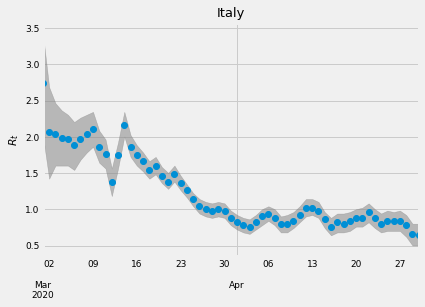

In [110]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.ylabel('$R_t$')
pandas.Series(middle, index=k.index[1:]).plot.line(lw=0, marker="o")
plt.fill_between(k.index[1:], lower, upper, color='grey', alpha=0.5)
plt.title(country)
plt.savefig(f'{country}_Rt.png', dpi=300, bbox_inches='tight')

# All-in-one function

In [40]:
country = 'Spain'
def estimate_R(country):
    de = df_c[country, float('nan')]
    de = de[de.index[(de > 30)][0]:]
    deltas = (de - de.shift(1)).dropna()
    k = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()
    tau = 1
    r_range = numpy.linspace(0, 10, 500)
    Tc = 5.2
    gamma = 1/Tc
    lambdas = numpy.outer(k[:-1],  numpy.exp(tau*gamma*(r_range - 1)))
    L = scipy.stats.poisson.pmf(k[1:], lambdas.T)
    P  = L.copy()
    W = 3
    for i in range(L.shape[1]):
        P[:,i] = L[:,i] / L[:,i].sum()
        for j in range(1, min(W, i)):
            P[:,i] *= L[:,i-j]
            P[:,i] /= P[:,i].sum()
    lower = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
    middle = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
    upper = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]
    return pandas.DataFrame({'median': middle, 'lower': lower, 'upper': upper, 'cases': k[1:]}, index=k.index[1:])

In [63]:
def plot_country(country_to_estimate):
    plt.figure()
    estimates = estimate_R(country_to_estimate)
    estimates['median'].plot.line(marker='o', lw=0)
    plt.ylabel('$R_t$')
    plt.fill_between(estimates.index, estimates['lower'], estimates['upper'], alpha=0.6, color='grey')
    estimates['cases'].plot.line(secondary_y=True)
    plt.ylabel('new cases')
    plt.title(country_to_estimate)

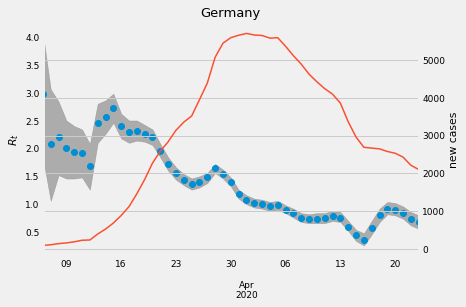

In [64]:
plot_country('Germany')

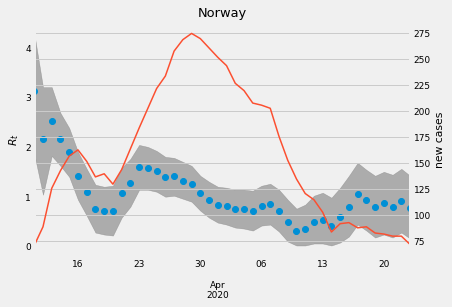

In [65]:
plot_country("Norway")

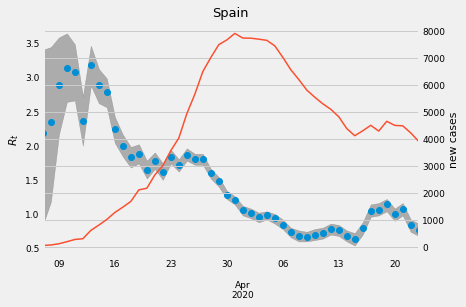

In [66]:
plot_country('Spain')

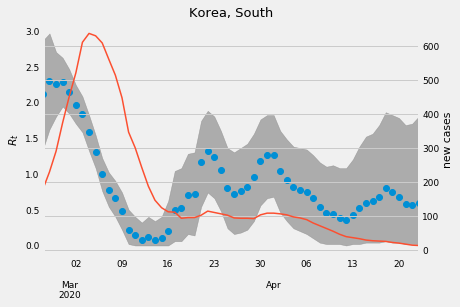

In [67]:
plot_country('Korea, South')

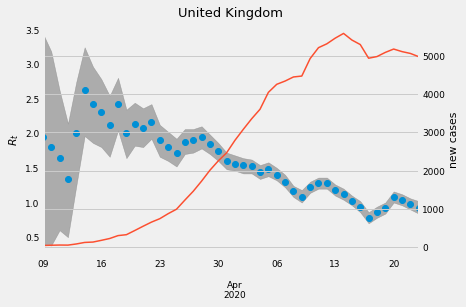

In [68]:
plot_country('United Kingdom')